In [1]:
def euler_distance(point1, point2):
    distance = 0.0
    for a, b in zip(point1, point2):
        distance += math.pow(a - b, 2)
    return math.sqrt(distance)


In [2]:
import math
import numpy as np
# 定义聚类树的节点
class ClusterNode:
    def __init__(self, vec, left=None, right=None, distance=-1, id=None, count=1):
        """
        vec: 保存两个数据merge后新的中心
        left: 左节点
        right: 右节点
        distance: 两个节点的距离
        id: 保存哪个节点是计算过的
        count: 这个节点的叶子节点个数
        """
        self.vec = vec
        self.left = left
        self.right = right
        self.distance = distance
        self.id = id
        self.count = count

In [3]:
# 层次聚类的类
# 不同于文中所说的先构建树，再进行切分，而是直接根据所需类别数目，聚到满足条件的节点数量即停止
# 和k-means一样，也需要指定类别数量
class Hierarchical:
    def __init__(self, k=1):
        assert k > 0
        self.k = k
        self.labels = None

    def fit(self, x):
        # 初始化节点各位等于数据的个数
        nodes = [ClusterNode(vec=v, id=i) for i, v in enumerate(x)]
        distance = {}
        point_num, feature_num = np.shape(x)
        self.labels = [-1] * point_num
        currentclustid = -1
        while len(nodes) > self.k:
#             print(len(nodes))
            min_dist = np.inf
            # 当前节点的个数
            nodes_len = len(nodes)
            # 最相似的两个类别
            closest_part = None
            # 当前节点中两两距离计算，找出最近的两个节点
            for i in range(nodes_len - 1):
                for j in range(i + 1, nodes_len):
                    # 避免重复计算
                    d_key = (nodes[i].id, nodes[j].id)
                    if d_key not in distance:
                        distance[d_key] = euler_distance(nodes[i].vec, nodes[j].vec)
                    d = distance[d_key]
                    if d < min_dist:
                        min_dist = d
                        closest_part = (i, j)
            part1, part2 = closest_part
            node1, node2 = nodes[part1], nodes[part2]
            # 将两个节点进行合并,即两个节点所包含的所有数据的平均值
            new_vec = [(node1.vec[i] * node1.count + node2.vec[i] * node2.count) / (node1.count + node2.count)
                       for i in range(feature_num)]
            new_node = ClusterNode(vec=new_vec, left=node1, right=node2, distance=min_dist, id=currentclustid,
                                   count=node1.count + node2.count)
            currentclustid -= 1
            # 删掉这最近的两个节点
            del nodes[part2], nodes[part1]
            # 把新的节点添加进去
            nodes.append(new_node)
        # 树建立完成，这里要注意，在示例中是最终凝聚为1个节点，而这里到达所要指定的类别数目即停止，一个node属于一个类别
        self.nodes = nodes
        # 给每个node以及node包含的数据打上标签
        self.calc_label()

    def calc_label(self):
        # 调取聚类结果
        for i, node in enumerate(self.nodes):
            self.leaf_traversal(node, i)

    def leaf_traversal(self, node: ClusterNode, label):
        # 递归遍历叶子结点
        if node.left is None and node.right is None:
            self.labels[node.id] = label
        if node.left:
            self.leaf_traversal(node.left, label)
        if node.right:
            self.leaf_traversal(node.right, label)

In [4]:
def evaluate(y_pre, y_true):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    overlap = 0
    union = 0
    for i, value in enumerate(y_true):
        if y_pre[i] == value and y_pre[i] == 1:
            TP += 1
            overlap += 1
            union += 1
        elif y_pre[i] == value and y_pre[i] == 0:
            TN += 1
        elif y_pre[i] != value and y_pre[i] == 0:
            FN += 1
            union += 1
        else:
            FP += 1
            union += 1
    # 像素准确性
    pixel_accuracy = (TP+TN)/(TP+TN+FP+FN)

    # IoU
    IoU = overlap / union

    # F1_score
    P = TP / (TP + FP)
    R = TP / (TP + FN)
    F1_score = 2 * P * R / (P+R)
    return pixel_accuracy, IoU, F1_score

In [5]:
import cv2
x1 = cv2.imread('cat11.png')
y1 = cv2.imread('cat11-true.png')
y1 = y1.reshape(-1, 3)
y_true = y1[:, 0]
y_true = y_true / 255
H = x1.shape[0]
W = x1.shape[1]
x1 = x1.reshape(-1, 3)
my = Hierarchical(4)
my.fit(x1)
data = x1.copy()
data = data.reshape(-1, 3)
back_label = my.labels[0]
y_pre = my.labels.copy()  # 背景0，物体1
for i, label in enumerate(my.labels):
    if label == back_label:
        data[i] = [0, 0, 0]
        y_pre[i] = 0
    else:
        data[i] = [255, 255, 255]
        y_pre[i] = 1
data = data.reshape(H, W, 3)
cv2.imwrite('cat1_result_HAC.png', data)
pixel_accuracy, IoU, F1_score = evaluate(y_pre, y_true)
print('pixel_accuracy, IoU, F1_score(HAC):' + str(pixel_accuracy) + ',' + str(IoU) + ',' + str(F1_score))

D:\XUEXI\anaconda3\envs\new_pytorch\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ubyte_scalars
  after removing the cwd from sys.path.


pixel_accuracy, IoU, F1_score(HAC):0.8924242424242425,0.7053941908713693,0.8272506082725061


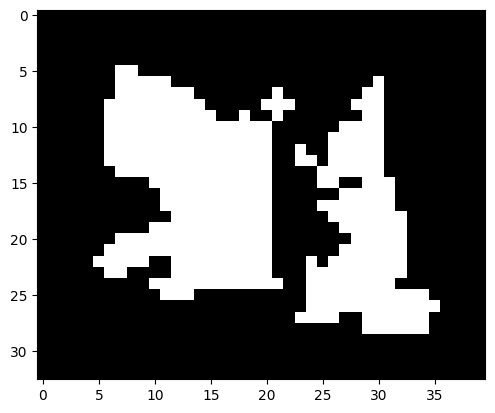

In [6]:
import matplotlib.pyplot as plt
plt.imshow(data)
plt.show()